<a href="https://colab.research.google.com/github/rland93/pendulum/blob/master/notebooks/lqr_state_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LQR + State Estimation with an Unscented Kalman Filter

This notebook explores state estimation with an Unscented Kalman Filter in the presence of external measurement noise.

In [6]:
!rm -rf pendulum
!git clone https://github.com/rland93/pendulum.git
!pip install filterpy

Cloning into 'pendulum'...
remote: Enumerating objects: 431, done.
remote: Counting objects: 100% (431/431), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 431 (delta 194), reused 365 (delta 136), pack-reused 0
Receiving objects: 100% (431/431), 6.98 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (194/194), done.
     |████████████████████████████████| 184kB 6.4MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110476 sha256=c68a4a2bd8793b46fce0bb0e3fecbe0d11341181cca9f0812239f388413659ed
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


import modules

In [7]:
import sys, os
sys.path.append('pendulum/')
print(sys.executable)
print(sys.version)

import numpy as np
import pandas as pd
from pendulum import controller, pendulum, sim, utils
from pendulum.viz import Visualizer
from IPython.display import HTML
import matplotlib.pyplot as plt

/usr/bin/python3
3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


Here we introduce measurement noise onto the simulation with the `noise_scale` parameter. We can adjust the variance of the noise (it is Gaussian noise internally, which would be common in a real-world sensor system) by changing the scale of each parameter.

In [8]:
dt, t_final = 0.01, 10
c1, c2, c3, c4, fshift = 12, 2.0, 4, .2, 3
def force_fn(t):
  return c1 * np.sin(c2*t) * c3/(c4*np.sqrt(np.pi)) * np.exp(-((t-fshift)/c4)**2)
noise_scale = [.1,.1,.1,.1]
simu = sim.Simulation(dt, t_final, force_fn, noise_scale=noise_scale)
pend = pendulum.Pendulum(4,1,3.0, cfric=.5, pfric=0.3, initial_state=np.array([0,0,0.1,0]))

We establish two controllers. One, `LQR` has no state estimator applied. The other, `LQR_UKF`, uses an Unscented Kalman Filter (UKF) to estimate the state. It still uses the same LQR (with the same `Q` and `R` parameters) to control the system.

`LQR_UKF` has an additional parameter, `s` that controls the "smoothness" of the estimation. Higher values of `s` will cause the estimator to lag, but will reduce noise more, whereas lower values of `s` will cause the estimator to be more repsonsive, but less efficient at reducing noise.

In [9]:
Q = [0,0,1,0]
R = 5e-6

cont_lqr = controller.LQR(pend, dt, 20, Q, R)
cont_ukf = controller.LQR_UKF(pend, dt, 20, Q, R, s=6, var_window=10)

In [10]:
res_lqr = simu.simulate(pend, cont_lqr)
res_ukf = simu.simulate(pend, cont_ukf)

100%|██████████| 1001/1001 [00:05<00:00, 182.78it/s]


This generates a plot of the estimated, true, and measured values for each variable. We are most interested in $theta$ (which is labeled `t` on this chart), but we also might consider the estimate of the other parameters to be important. Our choices for the filter variables (in the controller class definitions) can change how these parameters are estimated. 

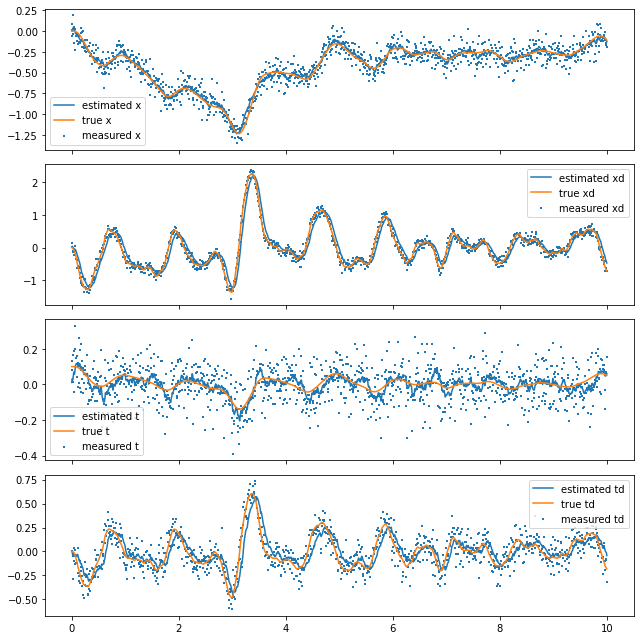

In [11]:
_, ax = plt.subplots(nrows=4, tight_layout=True, sharex=True, figsize=(9,9))
for i, s in enumerate(res_ukf['state']):
  ax[i].scatter(res_ukf.index, res_ukf[('measured state', s)].values, label = 'measured ' + s,marker = '+',s=5)
  ax[i].plot(res_ukf[('est', s)] ,  label = 'estimated ' + s)
  ax[i].plot(res_ukf[('state', s)], label = 'true ' + s)
  ax[i].legend()

A parameter that is important for filter tuning is the variance. Variance is sometimes specified in advance (like, if you knew from the sensor specifications, or could test it a priori) but here it is measured. Taking the standard deviation over a rolling window of size `var_window` gives us the variance of the measured state. A shorter window allows the variance to change more quickly (improving our filter responsiveness) but may reduce the filter accuracy (as less measurements are used).  

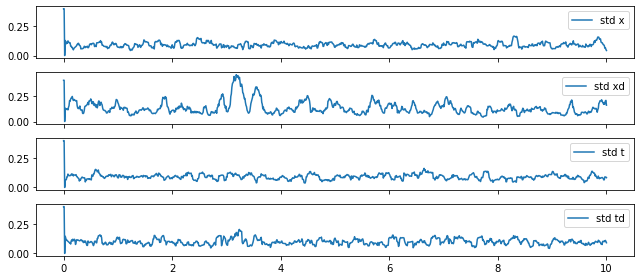

In [12]:
_, ax2 = plt.subplots(nrows=4, tight_layout=True, sharex=True, figsize=(9,4))
for i, s in enumerate(res_ukf['state']):
    ax2[i].plot(res_ukf[('var',s)], label='std '+s)
    ax2[i].legend()

Here, we see perhaps the clearest benefit of the state estimator: a significant reduction in actuation. Not only does the state estimator confer stability benefits, it also prevents the controller from actuating based on state noise. This means a reduction in wear, energy use, (in a physical system), etc.

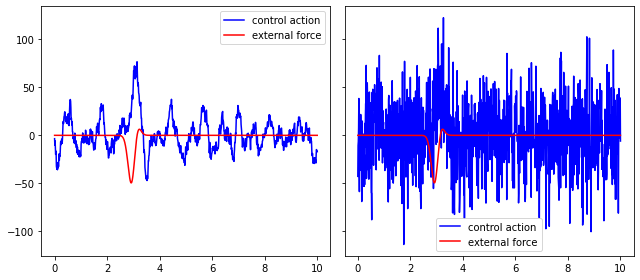

In [14]:
_, ax3 = plt.subplots(ncols=2, figsize=(9,4), tight_layout=True, sharey=True, sharex=True)
ax3[0].plot(res_ukf[('control action')], 'b', label='control action')
ax3[0].plot(res_ukf[('forces')], 'r', label='external force')
ax3[0].legend()
ax3[1].plot(res_lqr[('control action')], 'b', label='control action')
ax3[1].plot(res_lqr[('forces')], 'r', label='external force')
ax3[1].legend()

Finally, we can see the results of our work in the animation. First, the LQR only controller: 

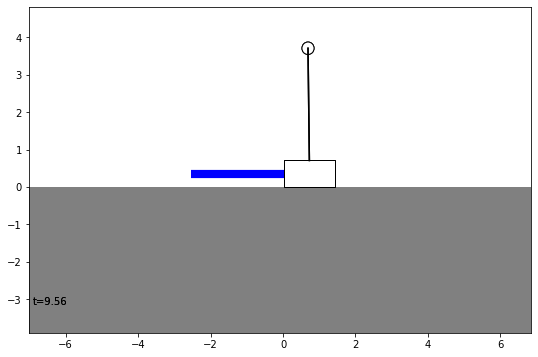

In [15]:
visu1 = Visualizer(res_lqr, pend, speed=4)
anim1 = visu1.animate()
HTML(anim1.to_html5_video())

Then, the LQR with state estimation:

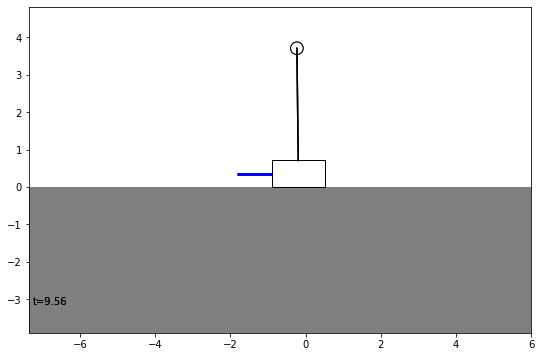

In [16]:
visu2 = Visualizer(res_ukf, pend, speed=4)
anim2 = visu2.animate()
HTML(anim2.to_html5_video())

We can see from this notebook that state estimation is very important, especially when the only measurements we have of the sytem state are noisy. 